### Deep neural network

**Implement a deep neural network model.**

*Using generated red and blue points that form two circles, we fit a neural network to classify the colored points.*


*Pseudocode of the algorithm*:

Forward step:
$$Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}$$
$$A^{[l]} = g^{[l]}(Z^{[l]})$$

Backward step:
$$dZ^{[l]} = dA^{[l]} * g^{[l]}(Z^{[l]})^{'}$$
$$dW^{[l]} = \frac{1}{m} dZ^{[l]}A^{[l-1]T}$$
$$db^{[l]} = \frac{1}{m} \sum^{m}_{i=1}{dZ^{[l](i)}}$$
$$dA^{[l-1]} = W^{[l]T}dZ^{[l]}$$

Cost function:
$$J(w,b) = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}log(a^{(i)}) + (1-y^{(i)})log(1-a^{(i)}))$$

Update weights:
$$W^{[l]} := W^{[l]} - \alpha dW^{[l]}$$
$$b^{[l]} := b^{[l]} - \alpha db^{[l]}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn import datasets
N = 200
noisy_circles = datasets.make_circles(n_samples=N, factor=.25, noise=.2)
X = noisy_circles[0].T
Y = noisy_circles[1].reshape(-1, len(noisy_circles[1]))
print("The shape of the input data", X.shape)
print("The shape of the labels", Y.shape, end='')

The shape of the input data (2, 200)
The shape of the labels (1, 200)

In [3]:
def initialize_params(layer_size):
    """
    Initialize weight and intercept parameters
    """
    np.random.seed(1)
    param = {}
    L = len(layer_size)
    for l in range(1,L):
        param['W' + str(l)] = np.random.randn(layer_size[l], layer_size[l-1]) / np.sqrt(layer_size[l-1])
        param['b' + str(l)] = np.zeros((layer_size[l], 1))
        assert(param['W' + str(l)].shape == (layer_size[l], layer_size[l-1]))
        assert(param['b' + str(l)].shape == (layer_size[l], 1))
    return param

def linear_forward(Aprev, W, b):
    """
    Compute the linear part "Z" of the forward propagation
    """
    np.random.seed(1)
    Z = np.dot(W, Aprev) + b
    cache = (Aprev, W, b)
    assert(Z.shape == (W.shape[0], Aprev.shape[1]))
    return Z, cache

def sigmoid(Z):
    """
    Sigmoid activation function
    """
    return 1 / (1+np.exp(-Z))

def relu(Z):
    """
    ReLU activation function
    """
    return np.maximum(0, Z)

def activation_forward(Aprev, W, b, activation):
    """
    Compute activation values "A" of the forward propagation
    """
    np.random.seed(1)
    Z, linear_cache = linear_forward(Aprev, W, b)
    if activation=='sigmoid':
        A = sigmoid(Z)
    if activation=='relu':
        A = relu(Z)        
    cache = (linear_cache, Z)
    assert(A.shape == Z.shape)
    return A, cache

def forward_prop(X, param, layer_size):
    """
    Forward propagation process
    """
    np.random.seed(1)
    caches = []
    Aprev = X
    L = len(layer_size)
    for l in range(1,L-1):
        A, cache = activation_forward(Aprev, param['W' + str(l)], param['b' + str(l)], 'relu')
        Aprev = A
        caches.append(cache)
    A, cache = activation_forward(Aprev, param['W' + str(L-1)], param['b' + str(L-1)], 'sigmoid')
    caches.append(cache)
    return A, caches

def linear_backward(dZ, cache):
    """
    Compute the linear part of the backward propagation
    """
    np.random.seed(1)
    Aprev = cache[0]
    W = cache[1]
    m = Aprev.shape[1]
    dW = 1/m * np.dot(dZ, Aprev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dAprev = np.dot(W.T, dZ)
    cache = (dAprev, dW, db)
    return cache

def sigmoid_backward(Z):
    """
    Derivative of the sigmoid activation function (use in backward propagation)
    """
    A = 1 / (1+np.exp(-Z))
    return np.multiply(A, (1 - A))

def relu_backward(Z):
    """
    Derivative of the ReLU activation function (use in backward propagation)
    """
    A = np.maximum(0, Z)
    A[A>0] = 1
    return A

def activation_backward(dA, cache, activation):
    """
    Compute the backward propagation for the LINEAR->ACTIVATION layer
    """
    np.random.seed(1)
    Z = cache[1]
    if activation=='sigmoid':
        dZ = dA * sigmoid_backward(Z)
    if activation=='relu':
        dZ = dA * relu_backward(Z)
    linear_cache = linear_backward(dZ, cache[0])
    return linear_cache

def backward_prop(Y, A, cache_fwd, layer_size):
    """
    Backward propagation process
    """
    np.random.seed(1)
    grads = {}    
    L = len(layer_size)
    dA = -(np.divide(Y, A) - np.divide(1-Y, 1-A))
    l = L -1
    cache = activation_backward(dA, cache_fwd[l-1], 'sigmoid')
    dA = cache[0]
    dW = cache[1]
    db = cache[2]
    grads['dW' + str(l)] = dW
    grads['db' + str(l)] = db
    
    for l in range(L-2,0,-1):
        cache = activation_backward(dA, cache_fwd[l-1], 'relu')
        dA = cache[0]
        dW = cache[1]
        db = cache[2]
        grads['dW' + str(l)] = dW
        grads['db' + str(l)] = db
    return grads

def update_params(param, grads, layer_size, alpha=0.001):
    """
    Update weight and intercept parameters
    """
    L = len(layer_size)
    for l in range(1,L):
        param['W' + str(l)] = param['W' + str(l)] - alpha * grads['dW' + str(l)]
        param['b' + str(l)] = param['b' + str(l)] - alpha * grads['db' + str(l)]
    return param

def cost(A, Y):
    """
    Calculate the cost function across training examples
    """
    m = Y.shape[1]
    J = -1/m * (np.dot(Y, np.log(A).T) + np.dot(1-Y, np.log(1-A).T))
    J = np.squeeze(J)
    return np.round(J, 3)

def predict(A, Y):
    pred = A.copy()
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    acc = np.sum(pred==Y) / Y.shape[1]
    return pred, acc

step 0, cost=0.699, acc=0.49
step 25000, cost=0.554, acc=0.735
step 50000, cost=0.31, acc=0.895
step 75000, cost=0.13, acc=0.96
step 100000, cost=0.1, acc=0.965
step 125000, cost=0.087, acc=0.97
step 150000, cost=0.08, acc=0.975
step 175000, cost=0.074, acc=0.97


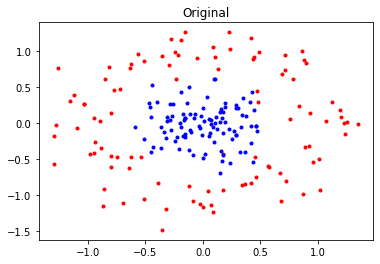

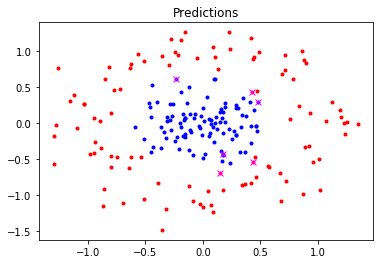

In [4]:
if __name__ == '__main__':
    layer_size = [2, 5, 5, 1]
    param = initialize_params(layer_size)
    nepochs = 200000
    for step in range(0,nepochs):
        A, cache = forward_prop(X, param, layer_size)
        if step%25000==0:
            J = cost(A, Y)
            pred, acc = predict(A, Y)
            print('step ', step, ', cost=', J, ', acc=', acc, sep='')
        grads = backward_prop(Y, A, cache, layer_size)
        param = update_params(param, grads, layer_size)

    plt.plot(X[0,np.squeeze(Y==0)], X[1,np.squeeze(Y==0)], '.', color='red')
    plt.plot(X[0,np.squeeze(Y==1)], X[1,np.squeeze(Y==1)], '.', color='blue')
    plt.title('Original')
    plt.show()

    #Plot the predictions
    plt.plot(X[0,np.squeeze(pred==0)], X[1,np.squeeze(pred==0)], '.', color='red')
    plt.plot(X[0,np.squeeze(pred==1)], X[1,np.squeeze(pred==1)], '.', color='blue')
    plt.plot(X[0,np.squeeze(pred!=Y)], X[1,np.squeeze(pred!=Y)], 'x', color='magenta')
    plt.title('Predictions')
    plt.show()